In [13]:
%pip install pandas mediapipe albumentations timm opencv-python scikit-learn matplotlib seaborn ipykernel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import mediapipe as mp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path
import timm
import torch.nn as nn

# Konfigurasi
CFG = {
    "data_root": "dataset-train/train", 
    "img_size": 224,
    "batch_size": 16,
    "num_workers": 0,
    "model_path": "face_deit_best.pth",
    "arch": "deit_tiny_patch16_224",
    "seed": 42
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [15]:
# --- MediaPipe Init & Preprocessing Functions ---
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.7)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
PREPROCESS_CACHE = {}

def read_image(path: str):
    try:
        bgr = cv2.imread(str(path))
        if bgr is not None:
            return bgr
    except:
        pass
    return None

def detect_and_align(bgr_img, image_size=224):
    rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    results = face_detector.process(rgb)
    if not results.detections:
        return None
    
    best_det = max(results.detections, key=lambda det: det.score[0])
    bbox = best_det.location_data.relative_bounding_box
    h, w, _ = rgb.shape
    
    x_min = int(bbox.xmin * w)
    y_min = int(bbox.ymin * h)
    box_w = int(bbox.width * w)
    box_h = int(bbox.height * h)
    
    margin = 0.2
    x_min = max(0, x_min - int(box_w * margin))
    y_min = max(0, y_min - int(box_h * margin))
    x_max = min(w, x_min + int(box_w * (1 + 2*margin)))
    y_max = min(h, y_min + int(box_h * (1 + 2*margin)))
    
    face_rgb = rgb[y_min:y_max, x_min:x_max]
    if face_rgb.size == 0: return None
    
    aligned = cv2.resize(face_rgb, (image_size, image_size))
    return aligned

def enhance_face(rgb_img):
    ycrcb = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YCrCb)
    ycrcb[:, :, 0] = clahe.apply(ycrcb[:, :, 0])
    eq_rgb = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    return cv2.bilateralFilter(eq_rgb, d=9, sigmaColor=75, sigmaSpace=75)

def preprocess_face(path: str):
    if path in PREPROCESS_CACHE: return PREPROCESS_CACHE[path]
    bgr = read_image(path)
    if bgr is None: return np.zeros((CFG['img_size'], CFG['img_size'], 3), dtype=np.uint8)
    
    face = detect_and_align(bgr, CFG['img_size'])
    if face is None: 
        face = cv2.resize(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB), (CFG['img_size'], CFG['img_size']))
    
    final_img = enhance_face(face)
    PREPROCESS_CACHE[path] = final_img
    return final_img

In [16]:
# --- CELL 3: Dataset Loading & Splitting ---
from sklearn.model_selection import train_test_split

# 1. Scan Folder untuk membuat DataFrame
data_root = Path(CFG["data_root"])
all_image_paths = list(data_root.glob("*/*")) # Asumsi struktur: root/kelas/foto.jpg
data = []

# Scan otomatis file gambar
for img_path in all_image_paths:
    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.webp']:
        label = img_path.parent.name
        data.append({"path": str(img_path), "label": label})

df_all = pd.DataFrame(data)

# 2. Encoding Label (Label -> Angka)
class_names = sorted(df_all['label'].unique())
label_to_idx = {name: i for i, name in enumerate(class_names)}
df_all['label_id'] = df_all['label'].map(label_to_idx)

print(f"Total Data Ditemukan: {len(df_all)}")
print(f"Jumlah Kelas (Orang): {len(class_names)}")

# 3. Split Data (PERBAIKAN: Menggunakan Random Split Biasa)
# Kita ambil 20% sebagai data validasi/test
try:
    _, df_val = train_test_split(
        df_all, 
        test_size=0.2, 
        random_state=CFG['seed'], 
        shuffle=True
    )
    df_val = df_val.reset_index(drop=True)
    print(f"Berhasil split data! Jumlah Data Test (Validation): {len(df_val)}")
except Exception as e:
    print(f"Error saat split: {e}")

# 4. Dataset Class (Wajib ada untuk pytorch)
class FaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Panggil fungsi preprocess dari Cell 2
        img = preprocess_face(row['path'])
        
        if self.transform:
            img = self.transform(image=img)['image']
            
        return img, row['label_id']

# 5. Transform & DataLoader
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Buat DataLoader
if len(df_val) > 0:
    test_dataset = FaceDataset(df_val, transform=val_transform)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CFG['batch_size'], 
        shuffle=False, 
        num_workers=CFG['num_workers']
    )
    print("DataLoader siap digunakan.")
else:
    print("WARNING: Data validation kosong. Cek path dataset Anda!")

Total Data Ditemukan: 280
Jumlah Kelas (Orang): 69
Berhasil split data! Jumlah Data Test (Validation): 56
DataLoader siap digunakan.


In [ ]:
# --- CELL 4: Load Model & Inference ---

# 1. Setup Model
# PENTING: paksa num_classes=70 sesuai pesan error (checkpoint punya 70)
# Walaupun data test cuma 69, model butuh wadah 70 agar bisa di-load.
model = timm.create_model(CFG['arch'], pretrained=False, num_classes=70)

# 2. Load Weights
if os.path.exists(CFG['model_path']):
    state_dict = torch.load(CFG['model_path'], map_location=device)
    
    if 'model' in state_dict:
        state_dict = state_dict['model']
    
    # Load state dict
    try:
        model.load_state_dict(state_dict)
        print("Model loaded successfully (70 classes)!")
    except Exception as e:
        print(f"Masih error: {e}")
else:
    print(f"WARNING: Model file '{CFG['model_path']}' not found. Check the path!")

model.to(device)
model.eval()

# 3. Run Inference
all_preds = []
all_labels = []

print("Running inference on validation set...")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        # Label dari dataset (0-68)
        labels = labels.numpy()
        
        # Output model (0-69)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        preds = preds.cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels)

print("Inference finished.")

Model loaded successfully (70 classes)!
Running inference on validation set...
Inference finished.


Accuracy: 0.4286

--- Classification Report ---
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       0.00      0.00      0.00         0
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         1
             Ahmad Faqih Hasani       1.00      1.00      1.00         1
                   Aldi Sanjaya       0.00      0.00      0.00         0
                        Alfajar       0.00      0.00      0.00         1
            Alief Fathur Rahman       0.00      0.00      0.00         1
 Arkan Hariz Chandrawinata Liem       1.00      1.00      1.00         2
               Bayu Ega Ferdana       1.00      1.00      1.00         1
          Bayu Prameswara Haris       1.00      1.00      1.00         1
           Bezalel Samuel Manik       0.00      0.00      0.00         0
           Bintang Fikri Fauzan       1.00      1.00      1.00         1
              Boy Sandro Sigiro       1.00      1.00      1.00         2
  

d:\attempt-baru\.venv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
d:\attempt-baru\.venv\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
d:\attempt-baru\.venv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
d:\attempt-baru\.venv\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of uni

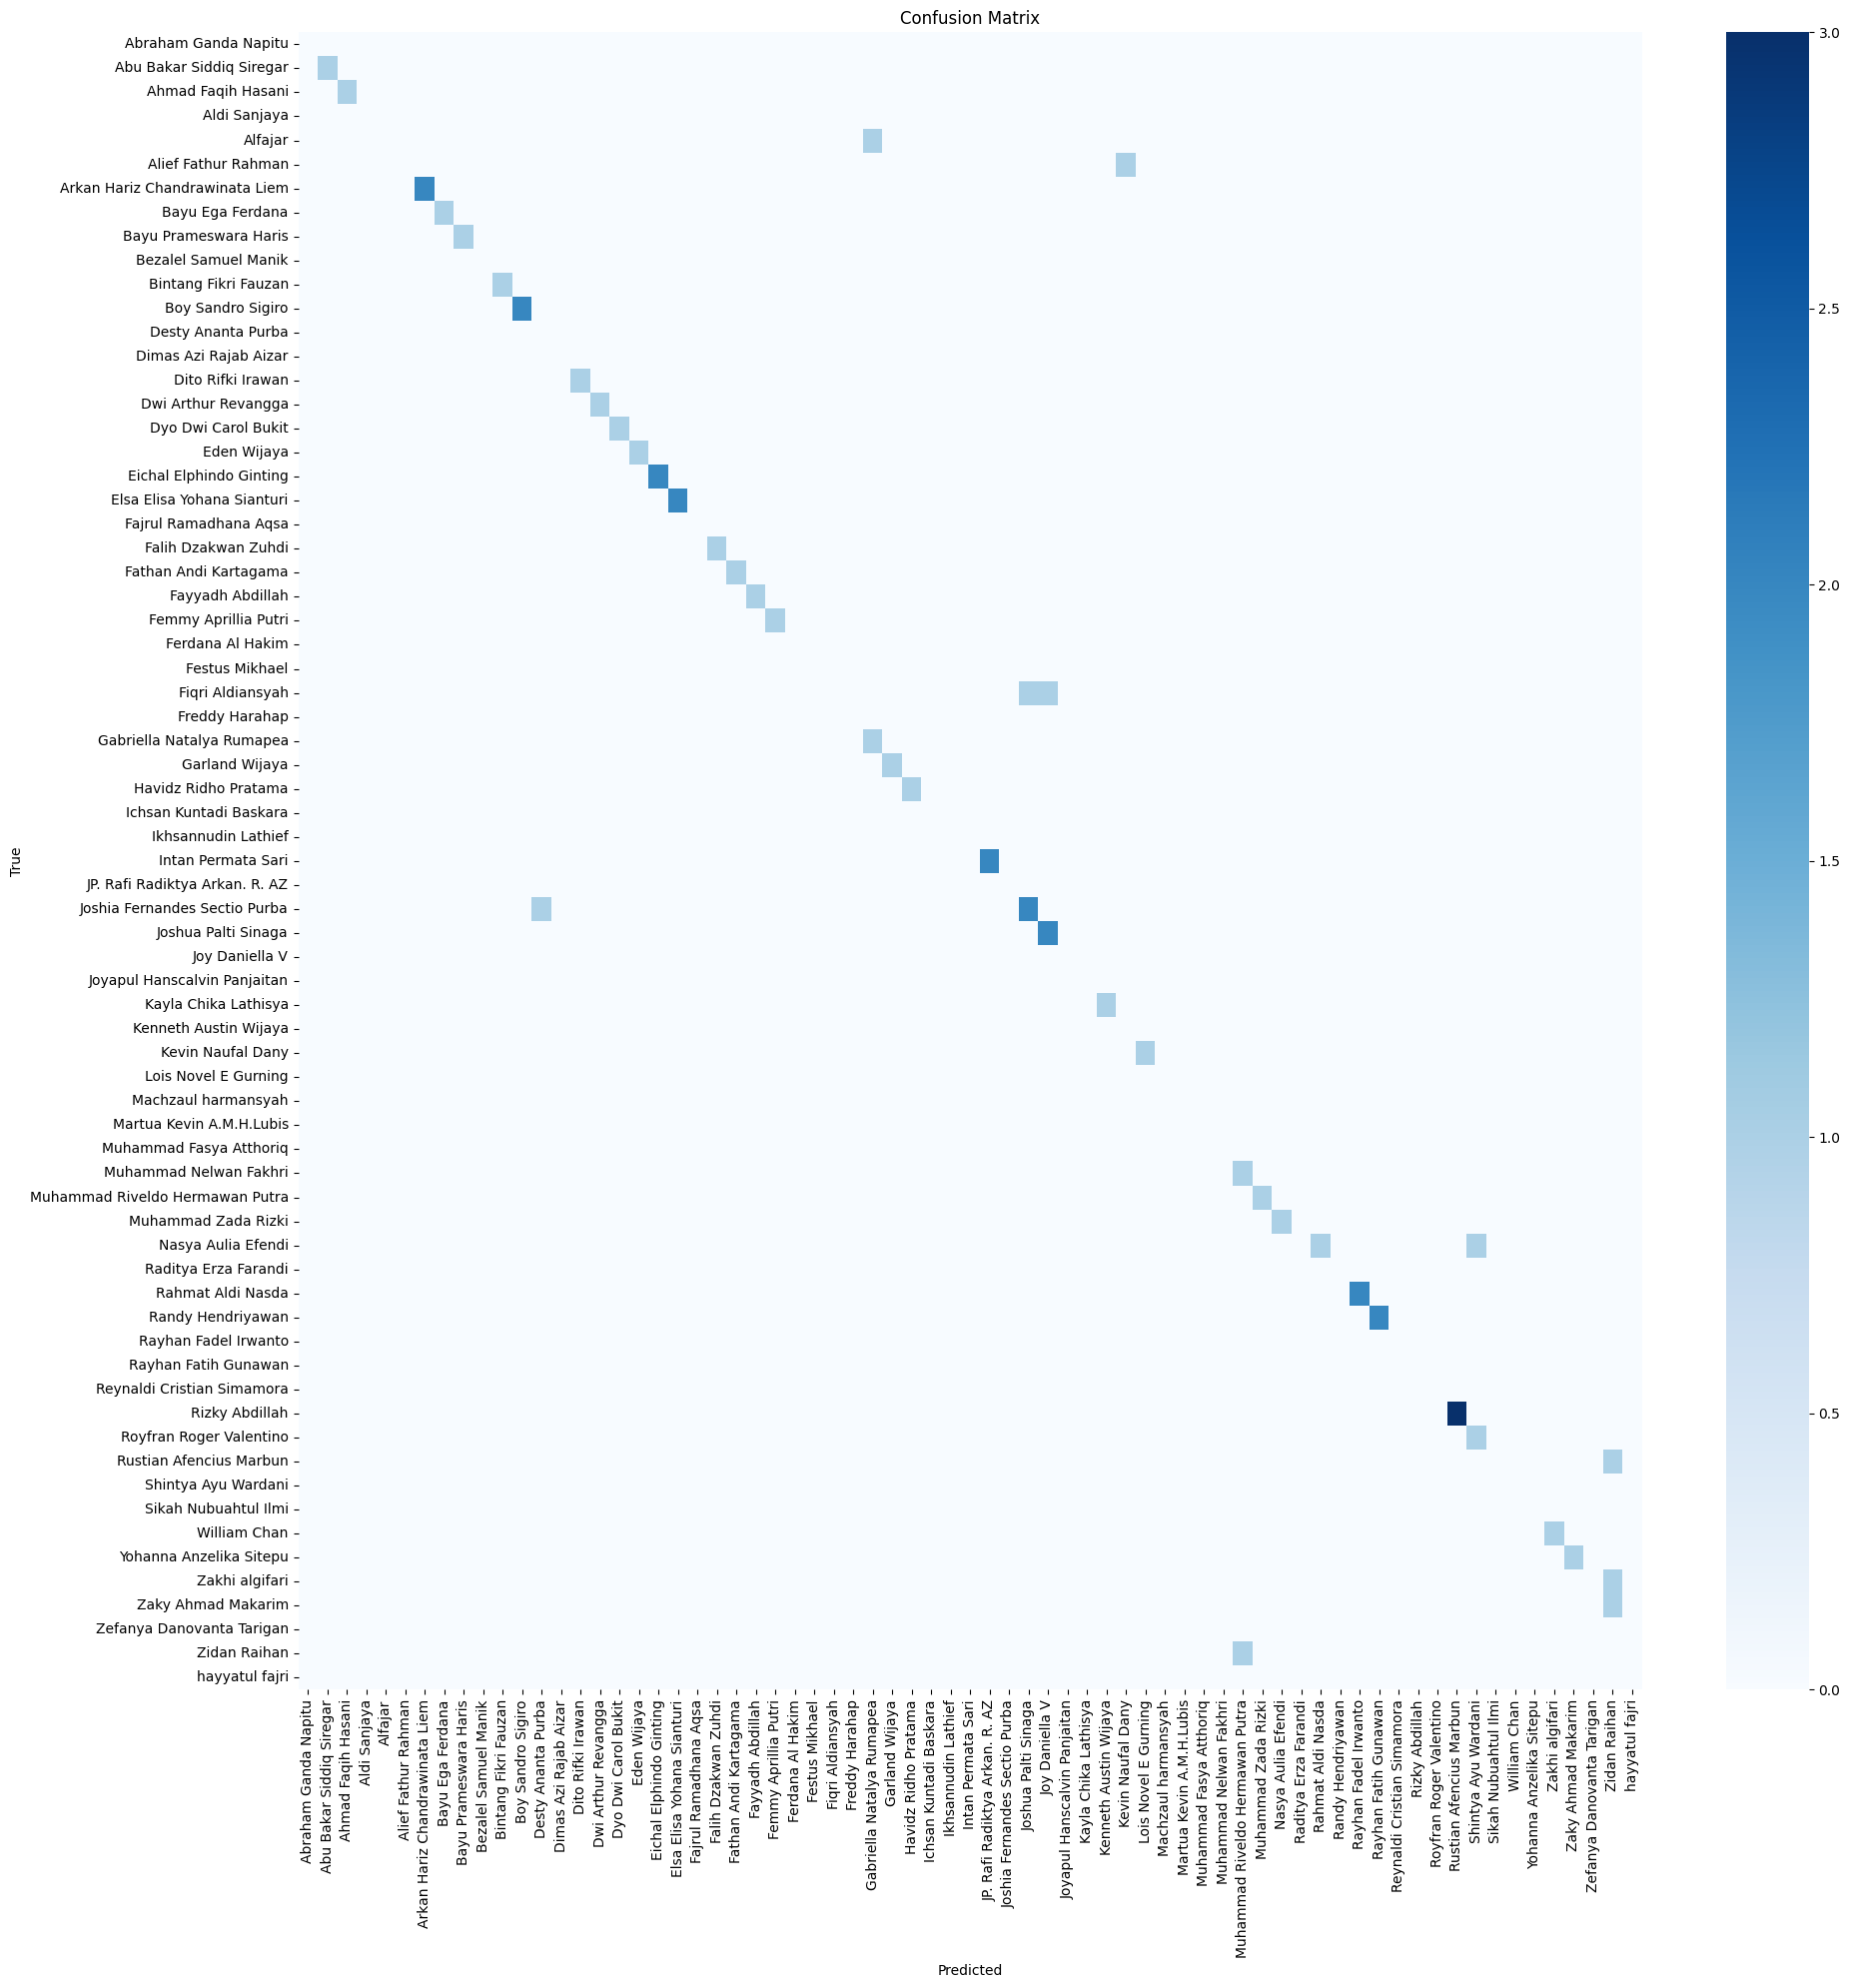

In [ ]:
# --- CELL 5: Evaluasi (Precision, Recall, F1) ---
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Hitung Akurasi
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}\n")

# 2. Classification Report
# Kita buat list ID lengkap (0 sampai 68) agar laporannya memuat SEMUA nama
# meskipun ada orang yang tidak muncul di data test.
all_class_ids = list(range(len(class_names)))

print("--- Classification Report ---")
# Tambahkan parameter 'labels' dan 'zero_division' agar tidak error
print(classification_report(
    all_labels, 
    all_preds, 
    labels=all_class_ids, 
    target_names=class_names, 
    zero_division=0
))

# 3. Confusion Matrix
# paksa matrix-nya berukuran 69x69
cm = confusion_matrix(all_labels, all_preds, labels=all_class_ids)

plt.figure(figsize=(20, 20)) # Ukuran diperbesar karena kelasnya banyak (69)
sns.heatmap(
    cm, 
    annot=False,   # Set True jika ingin melihat angkanya (bisa penuh sesak)
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90) # Putar nama agar terbaca
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()